## UPF Expeiments
    Feb2024

In [1]:

import os
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                             recall_score, roc_auc_score, mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
import xgboost as xgb
import math
import shap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


from config import region_mapping, set1, to_model_a, to_model_c, to_model_ac, to_model, set10


path = '/Users/jerzybala/Desktop/Simulation Experiments Aug-Sep 2023/PROCESSED_FOOD_Dec2023.csv'

path_temp = '/Volumes/2TB Ext/BrainBaseMHQ/mhm_data_2024-02-03_17-00-42_from jan2023.csv'

path_temp_processed = '/Volumes/2TB Ext/BrainBaseMHQ/GMP_data_2023_to_jan2024.csv'

df = pd.read_csv(path, low_memory=False)





df.loc[:, 'Processed food in diet'] = df['Processed food in diet'].replace({
            'Rarely/never': 'Rarely/Never',
            'A few times in a day': 'Several times a day',
            'Several days a week': 'A few times a week',
            'Many times in a day': 'Several times a day',
            'At least once a day': 'Several times a day'
        })


print(f"Data loaded. Shape: {df.shape}")



Data loaded. Shape: (401682, 239)


## Frequency feature numerical codding 

In [2]:


frequency_features = [
'Frequency of getting a good nights sleep',
'Frequency of doing exercise',
'Processed food in diet',
'Frequency of Socializing']

for f in frequency_features:
    print(f"{f}: {df[f].unique()}") 




df.loc[:, 'Frequency of getting a good nights sleep'] = df['Frequency of getting a good nights sleep'].replace({
    'Some of the time': 3,  # Occasional good sleep might be better than "Most days" depending on interpretation
    'Most of the time': 1,  # Most frequent good sleep
    'All of the time': 0,   # Always getting a good night's sleep
    'Hardly ever': 4,       # Rarely getting a good night's sleep
    'Most days': 2          # Assuming "Most days" is similar to "Some of the time", but could be adjusted based on interpretation
})


df.loc[:, 'Frequency of doing exercise'] = df['Frequency of doing exercise'].replace({
    'Less than once a week': 5,
    'Rarely/Never': 6,
    'Few days a week': 3,
    'Once a week': 4,
    'Every day': 1,
    'Some days of the week': 2, # Assuming this is less than "Every day" but more than "Few days a week"
    'Several days a week': 3    # Similar to "Few days a week"
})



df.loc[:, 'Processed food in diet'] = df['Processed food in diet'].replace({
    'A few times a week': 3,
    'Rarely/Never': 1,
    'A few times a month': 2,
    'Several times a day': 5,
    'Once a day': 4
})



df.loc[:, 'Frequency of Socializing'] = df['Frequency of Socializing'].replace({ 
    '1-3 times a month': 2,
    'Rarely/Never': 4,
    'Once a week': 3,
    'Several days a week': 1
})




Frequency of getting a good nights sleep: ['Some of the time' 'Most of the time' 'All of the time' 'Hardly ever'
 'Most days']
Frequency of doing exercise: ['Less than once a week' 'Rarely/Never' 'Few days a week' 'Once a week'
 'Every day' 'Some days of the week' 'Several days a week']
Processed food in diet: ['A few times a week' 'Rarely/Never' 'A few times a month'
 'Several times a day' 'Once a day']
Frequency of Socializing: ['1-3 times a month' 'Rarely/Never' 'Once a week' 'Several days a week']


In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [3]:
# Execute the following code to create a new dataframe with only the features of interest

df_features = df[set10].copy()

## Function Definitions

In [4]:
def segment_and_prepare_df(df, countries=None, age_groups=None, drop_list=None):
    """
    Segments the DataFrame based on specific countries and age groups, and then drops specified columns.
    
    Parameters:
    - df: DataFrame to be processed.
    - countries: List of countries for segmentation. If None, no country-based segmentation is applied.
    - age_groups: List of age groups for segmentation. If None, no age-based segmentation is applied.
    - drop_list: List of columns to be dropped from the DataFrame.
    
    Returns:
    - A DataFrame that has been segmented and had specified columns dropped.
    """
    # Segment DataFrame based on provided countries and age groups
    segmented_df = df.copy()
    if countries is not None:
        segmented_df = segmented_df[segmented_df['Country'].isin(countries)]
    if age_groups is not None:
        segmented_df = segmented_df[segmented_df['Age'].isin(age_groups)]
    
    # Drop specified columns if drop_list is provided
    if drop_list is not None:
        segmented_df = segmented_df.drop(columns=drop_list)
    
    return segmented_df
#================================================================================================


def encode_features(df, categorical_features):
    """Encodes categorical features using one-hot encoding."""
    encoded_features = pd.get_dummies(df[categorical_features])
    return pd.concat([df.drop(columns=categorical_features), encoded_features], axis=1)
#================================================================================================


def prepare_dataset(df, target_classification, target_regression):
    """Prepares the dataset by dropping specified columns, encoding categorical features, and splitting into features and targets."""
    #df_filtered = drop_columns(df, drop_list)
    categorical_features = df.select_dtypes(include=['object']).columns
    df_filtered = encode_features(df, categorical_features)
    
    X = df_filtered.drop(columns=[target_classification, target_regression], axis=1)
    y_classification = df_filtered[target_classification]
    y_regression = df_filtered[target_regression]
    
    return X, y_classification, y_regression

#================================================================================================

def split_dataset(X, y_classification, y_regression, test_size=0.3, random_state=42):
    """Splits the dataset into training and testing sets for both classification and regression tasks."""
    X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=test_size, random_state=random_state)
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train_class, y_test_class, X_train_reg, X_test_reg, y_train_reg, y_test_reg

#================================================================================================





In [5]:
drop_list = [

    'Country',

    'Household Income',

    'ARCHIVED: Smartphone ownership',
    'ARCHIVED: Age of smartphone access',
    'Smartphone allowed in school',
    'Smartphone use in lessons',

    'Smartphone ownership',
    'Friends/classmates smarphone ownership',
    'Age of smartphone usage during school hours',
    'Smartphone usage during class hours',
    'Smartphone usage during break'

]

anglosphere = ['United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'Ireland']
kraj = ['United States']
kraj2 =['India']
wiek = ['18-24', '21-24', '18', '19', '20']
wiek2 = ['55-64','45-54']


# Segment and prepare the DataFrame
prepared_df = segment_and_prepare_df(df_features, countries=None, age_groups=None, drop_list=drop_list)


prepared_df.shape

(401682, 46)

In [ ]:
#prepared_df.columns.to_list()

### New Features

In [7]:

# Features construcrs defined in config.py
# 'Legal_Substance_Use'
# 'Interpersonal_Trauma'
# 'Life_Adversities'


from config import Legal_Substance_Use, Interpersonal_Trauma, Life_Adversities


prepared_df['Legal_Substance_Use'] = prepared_df[Legal_Substance_Use].sum(axis=1)
prepared_df['Interpersonal_Trauma'] = prepared_df[Interpersonal_Trauma].sum(axis=1)
prepared_df['Life_Adversities'] = prepared_df[Life_Adversities].sum(axis=1)


prepared_df.to_csv('/Users/jerzybala/Desktop/prepared_df.csv', index=False)



## Feature Exploreation

In [ ]:
prepared_df.columns.to_list()

In [ ]:
# Include or not to include UPF

prepared_df=prepared_df.drop('Processed food in diet', axis=1)


In [8]:
import numpy as np
from scipy.stats import entropy

def calculate_infogain(df, target):
    # Calculate the entropy of the target variable
    target_entropy = entropy(df[target].value_counts(normalize=True), base=2)
    
    # Calculate the entropy of each feature
    feature_entropies = []
    for column in df.columns:
        if column != target:
            feature_entropy = 0
            for value in df[column].unique():
                subset = df[df[column] == value]
                subset_entropy = entropy(subset[target].value_counts(normalize=True), base=2)
                feature_entropy += (len(subset) / len(df)) * subset_entropy
            feature_entropies.append(feature_entropy)
    
    # Calculate the information gain for each feature
    infogains = target_entropy - np.array(feature_entropies)
    
    # Create a dictionary mapping each feature to its information gain
    infogain_dict = dict(zip(df.columns[df.columns != target], infogains))
    
    return infogain_dict


In [11]:
#prepared_df_c =prepared_df.drop(columns='Overall MHQ', axis=1)


info_gained_features = calculate_infogain(prepared_df_c, 'MHQ_Sign')


In [13]:
from tabulate import tabulate

def print_sorted_feature_scores(feature_scores, score_name="Score", table_format="grid"):
    """
    Sorts a dictionary of features and their scores in descending order and prints it in tabulated format.

    Parameters:
    - feature_scores: Dictionary with features as keys and scores as values.
    - score_name: A string representing the name of the score for the header. Defaults to "Score".
    - table_format: A string representing the table format to be used by tabulate. Defaults to "grid".
    """
    # Convert the dictionary to a list of tuples and sort it in descending order by score
    feature_scores_sorted = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Print the sorted list in tabulate format with customizable headers
    print(tabulate(feature_scores_sorted, headers=["Feature", score_name], tablefmt=table_format))

# Example usage for information gain:
print_sorted_feature_scores(info_gained_features, score_name="Information Gain")




+---------------------------------------------------------------------------------------+--------------------+
| Feature                                                                               |   Information Gain |
+=======================================================================================+====================+
| Age                                                                                   |        0.0712593   |
+---------------------------------------------------------------------------------------+--------------------+
| Interpersonal_Trauma                                                                  |        0.0461395   |
+---------------------------------------------------------------------------------------+--------------------+
| Frequency of getting a good nights sleep                                              |        0.0411      |
+---------------------------------------------------------------------------------------+--------------------+
|

In [14]:
## Write to Excel

# Convert the dictionary to a DataFrame
features_ranks = pd.DataFrame(list(info_gained_features.items()), columns=['Feature', 'Information Gain'])

# Sort the DataFrame by 'Information Gain' in descending order
features_ranks_sorted = features_ranks.sort_values(by='Information Gain', ascending=False)

# Specify the file path (adjust the path as necessary for your system)
file_path = '/Users/jerzybala/Desktop/sapien_temp.xlsx'

# Write the sorted DataFrame to an Excel file
features_ranks_sorted.to_excel(file_path, index=False, engine='openpyxl')

print(f"Feature scores have been written to {file_path}")




Feature scores have been written to /Users/jerzybala/Desktop/sapien_temp.xlsx


In [ ]:
# File deletion

#  CAREFUL! This will delete the file at the specified path
# ******************************************************

# After ensuring the file is no longer needed, delete it
os.remove(file_path)
print(f"The file {file_path} has been deleted.")


In [15]:

list1 = ['Interpersonal_Trauma', 'Age', 'Legal_Substance_Use', 'Life_Adversities']


for l in list1:
    a = prepared_df[l].unique().tolist()
    print(f"{l}: {a}, number of unique={len(a)}")   




Interpersonal_Trauma: [1, 0, 2, 4, 3, 5, 7, 6, 8], number of unique=9
Age: ['55-64', '35-44', '45-54', '18-24', '25-34', '65-74', '85+', '75-84', '21-24', '18', '19', '20', nan], number of unique=13
Legal_Substance_Use: [2, 0, 1, 3, 4, 5, 6], number of unique=7
Life_Adversities: [1, 2, 0, 5, 4, 3, 6, 7, 8, 9, 10, 14, 11, 12, 13], number of unique=15


In [ ]:
prepared_df.to_csv('/Users/jerzybala/Desktop/prepared_df.csv', index=False)

In [16]:

X, y_classification, y_regression = prepare_dataset(prepared_df, 'MHQ_Sign', 'Overall MHQ')

X_train, X_test, y_train, y_test, X_train_reg, X_test_reg, y_train_reg, y_test_reg = split_dataset(
    X, 
    y_classification, 
    y_regression, 
    test_size=0.3, 
    random_state=42
)


In [17]:


par1 = {
    'n_estimators': 200, 
    'learning_rate': 0.01,
    'max_depth': 10, 
    'min_child_weight': 1, 
    'gamma': 0.01, 
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Initialize XGBoost classifier and train

model_C = xgb.XGBClassifier(**par1)
model_C.fit(X_train, y_train)

# Predict and evaluate
predictions = model_C.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
auc = roc_auc_score(y_test, model_C.predict_proba(X_test)[:, 1])

print("xgb.XGBClassifier:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")
print("\n")


#==================================================================================================


# Initialize XGBoost regressor and train
#model = xgb.XGBRegressor()
# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.3, random_state=42)


#model_R = xgb.XGBRegressor()

model_R = xgb.XGBRegressor(
n_estimators=500,
learning_rate=0.1,
max_depth=6,
min_child_weight=1,
gamma=0.2,
subsample=0.4,
colsample_bytree=0.8,
#reg_alpha=10,
reg_lambda=0.1
)

model_R.fit(X_train_reg, y_train_reg)

# Separate predictions based on the sign of y_test
predictions = model_R.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, predictions)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_reg, predictions)
mae = mean_absolute_error(y_test_reg, predictions)

print("xgb.XGBRegressor:")
print('mae:', mae)
print('rmse:',rmse)
print('r2:', r2)
print("\n")



xgb.XGBClassifier:
Accuracy: 0.7895937927886809
F1 Score: 0.8721826495067274
Precision: 0.7992073243964857
Recall: 0.9598238061423753
AUC: 0.7954465513652414


xgb.XGBRegressor:
mae: 47.818749222442214
rmse: 58.829207338950766
r2: 0.3521781889790584




In [18]:
import shap

explainer_C = shap.Explainer(model_C)
shap_values_C = explainer_C(X_train)



[13:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[13:39:36] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


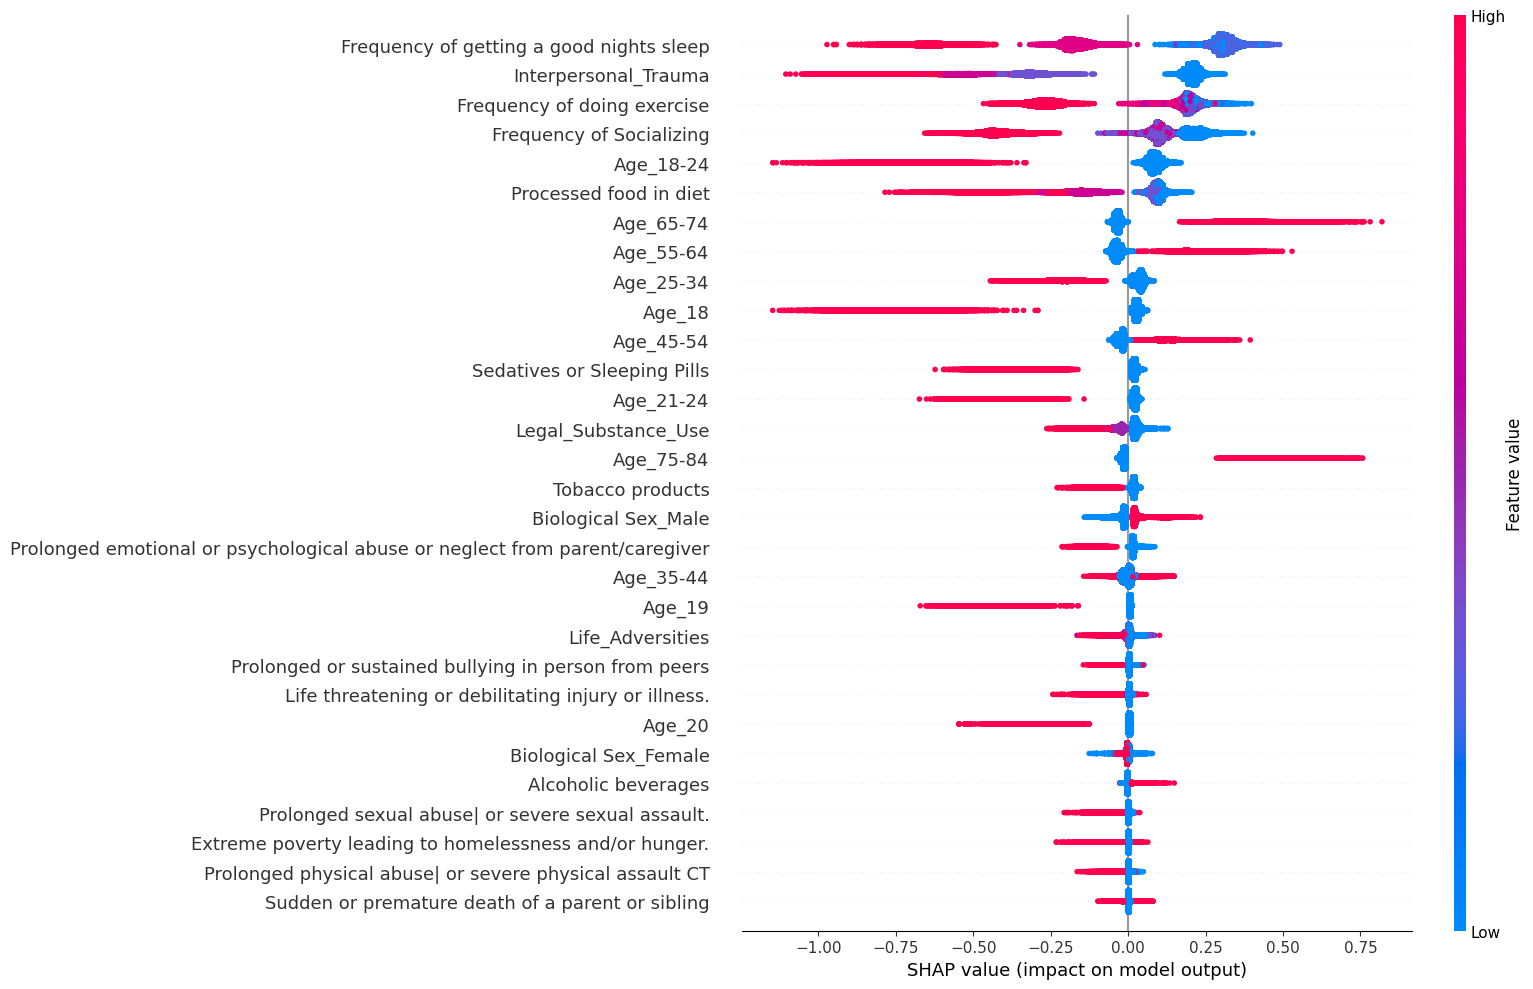

In [21]:
# Now use the shap.summary_plot with the subset of SHAP values and the corresponding X_train subset
shap.summary_plot(shap_values_C, X_train, plot_size=(16,10), max_display=30, show=False)


In [ ]:

frequency_features = [
'Frequency of getting a good nights sleep',
'Frequency of doing exercise',
'Processed food in diet',
'Frequency of Socializing']


feature_names = X_train.columns  # Adjust if your feature names are stored differently
desired_feature_indices = [i for i, feature in enumerate(feature_names) if feature in frequency_features]


# This assumes shap_values_C.values is a structured array or similar where the first dimension is samples and the second is features
subset_shap_values_array = shap_values_C.values[:, desired_feature_indices]



X_train_subset = X_train[frequency_features]

# Now use the shap.summary_plot with the subset of SHAP values and the corresponding X_train subset
shap.summary_plot(subset_shap_values_array, X_train_subset, plot_size=(16,10))

In [35]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def test_model_with_modified_X_test(X_test, y_test, model, percentage_change):
    # Make sure percentage_change is between 0 and 1
    if not 0 <= percentage_change <= 1:
        raise ValueError("percentage_change must be between 0 and 1.")
    
    # Make a copy of X_test to avoid changing the original data
    X_test_modified = X_test.copy()

    # Iterate over the unique values except 5
    for value in [1, 2, 3, 4]:
        # Find the indices where 'Processed food in diet' equals the current value
        indices = X_test_modified[X_test_modified['Processed food in diet'] == value].index
        # Calculate how many entries to replace
        num_entries_to_replace = int(len(indices) * percentage_change)
        # Randomly select entries to replace
        indices_to_replace = np.random.choice(indices, size=num_entries_to_replace, replace=False)
        # Replace the selected entries with 5
        X_test_modified.loc[indices_to_replace, 'Processed food in diet'] = 5

    # Predict with the modified X_test
    predictions_proba = model.predict_proba(X_test_modified)

    # Evaluation
    predictions = np.argmax(predictions_proba, axis=1)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions_proba[:, 1])

    # Output results
    print("xgb.XGBClassifier results with modified X_test:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUC: {auc}")
    print("\nPredicted Probabilities for each data point:\n", predictions_proba)

    return accuracy, f1, precision, recall, auc, predictions_proba



In [40]:
accuracy, f1, precision, recall, auc, predictions_proba = test_model_with_modified_X_test(X_test, y_test, model_C, 0.9)





xgb.XGBClassifier results with modified X_test:
Accuracy: 0.7866644537571055
F1 Score: 0.8641168759778426
Precision: 0.8251433416781071
Recall: 0.9069545535238771
AUC: 0.7867117407372565

Predicted Probabilities for each data point:
 [[0.20045269 0.7995473 ]
 [0.2185995  0.7814005 ]
 [0.44856566 0.55143434]
 ...
 [0.5469827  0.4530173 ]
 [0.16285503 0.837145  ]
 [0.2418257  0.7581743 ]]


In [23]:
model_C

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

def test_regressor_with_modified_X_test(X_test_reg, y_test_reg, model, percentage_change):
    # Make sure percentage_change is between 0 and 1
    if not 0 <= percentage_change <= 1:
        raise ValueError("percentage_change must be between 0 and 1.")
    
    # Make a copy of X_test_reg to avoid changing the original data
    X_test_modified = X_test_reg.copy()

    # Iterate over the unique values except 5
    for value in [1, 2, 3, 4]:
        # Find the indices where 'Processed food in diet' equals the current value
        indices = X_test_modified[X_test_modified['Processed food in diet'] == value].index
        # Calculate how many entries to replace
        num_entries_to_replace = int(len(indices) * percentage_change)
        # Randomly select entries to replace
        indices_to_replace = np.random.choice(indices, size=num_entries_to_replace, replace=False)
        # Replace the selected entries with 5
        X_test_modified.loc[indices_to_replace, 'Processed food in diet'] = 5

    # Predict with the modified X_test_reg
    predictions = model.predict(X_test_modified)

    # Evaluation
    mse = mean_squared_error(y_test_reg, predictions)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test_reg, predictions)
    mae = mean_absolute_error(y_test_reg, predictions)

    # Output results
    print("xgb.XGBRegressor results with modified X_test_reg:")
    print('Mean Absolute Error:', mae)
    print('Root Mean Squared Error:', rmse)
    print('R-squared:', r2)
    print("\nPredicted Values for each data point:\n", predictions)

    return mae, rmse, r2, predictions


In [37]:
test_regressor_with_modified_X_test(X_test_reg, y_test_reg, model_R, 0.5)

xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 50.78928910841389
Root Mean Squared Error: 61.71480607908116
R-squared: 0.2870676697208373




(50.78928910841389, 61.71480607908116, 0.2870676697208373)

In [42]:
mae, rmse, r2, predictions =test_regressor_with_modified_X_test(X_test_reg, y_test_reg, model_R, 0.5)

xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 50.728835925892895
Root Mean Squared Error: 61.67613816631784
R-squared: 0.28796077691993194

Predicted Values for each data point:
 [ 81.57212   94.71776   17.10557  ...  14.819913 103.66327   95.45752 ]


In [43]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_test_reg, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_reg, predictions, alpha=0.3)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=4)
    plt.show()

# Assuming y_test_reg and predictions are already defined
# plot_actual_vs_predicted(y_test_reg, predictions)


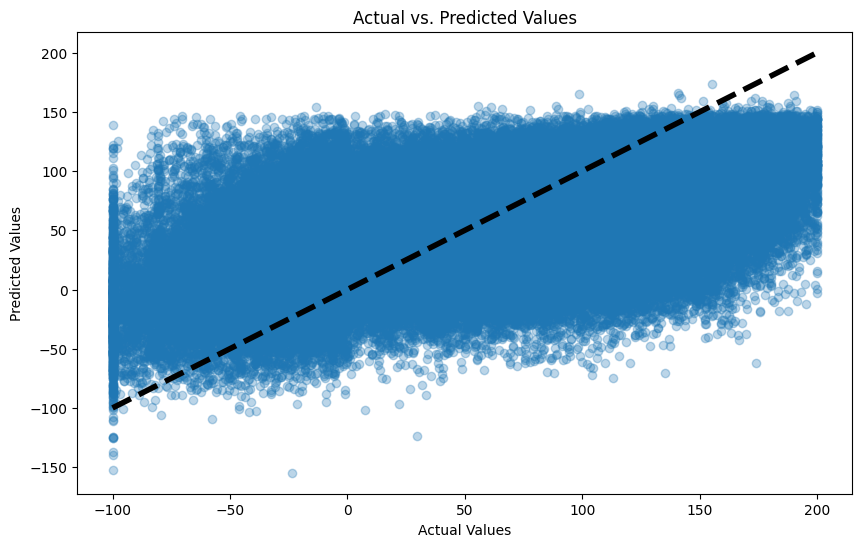

In [44]:
# Assuming y_test_reg and predictions are already defined
plot_actual_vs_predicted(y_test_reg, predictions)

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram_with_averages(predictions, num_bins=20):
    # Calculate histogram data
    counts, bin_edges = np.histogram(predictions, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate the average prediction per bin
    averages = [predictions[(predictions >= bin_edges[i]) & (predictions < bin_edges[i+1])].mean() for i in range(num_bins)]
    
    # Plot the histogram
    plt.figure(figsize=(12, 6))
    plt.hist(predictions, bins=num_bins, alpha=0.5, label='Frequency')
    
    # Plot the average line per bin
    plt.scatter(bin_centers, averages, color='red', label='Bin Averages')
    
    # Add a line representing the overall average
    overall_avg = np.mean(predictions)
    plt.axhline(overall_avg, color='green', linestyle='dashed', linewidth=2, label=f'Overall Average: {overall_avg:.2f}')
    
    # Add labels and title
    plt.title('Histogram of Predicted Values with Bin Averages')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()




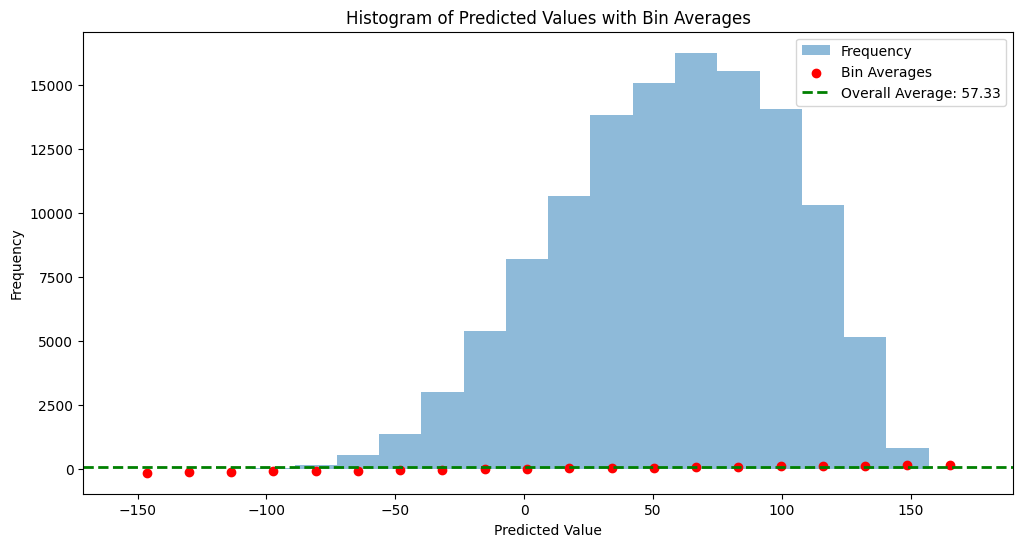

In [52]:
# Assuming 'predictions' is already defined
plot_histogram_with_averages(predictions)

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_line_graph_of_bin_averages(predictions, num_bins=10):
    # Calculate histogram data to determine bin edges
    _, bin_edges = np.histogram(predictions, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate the average prediction per bin
    bin_averages = [np.mean(predictions[(predictions >= bin_edges[i]) & (predictions < bin_edges[i+1])]) for i in range(len(bin_centers))]

    # Plot the line graph of averages
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, bin_averages, 'o-', color='red', label='Average Predicted Value')
    
    # Add labels and title
    plt.title('Average Predicted Values per Bin')
    plt.xlabel('Predicted Value Bins')
    plt.ylabel('Average Predicted Value')
    plt.legend()
    plt.grid(True)
    plt.show()




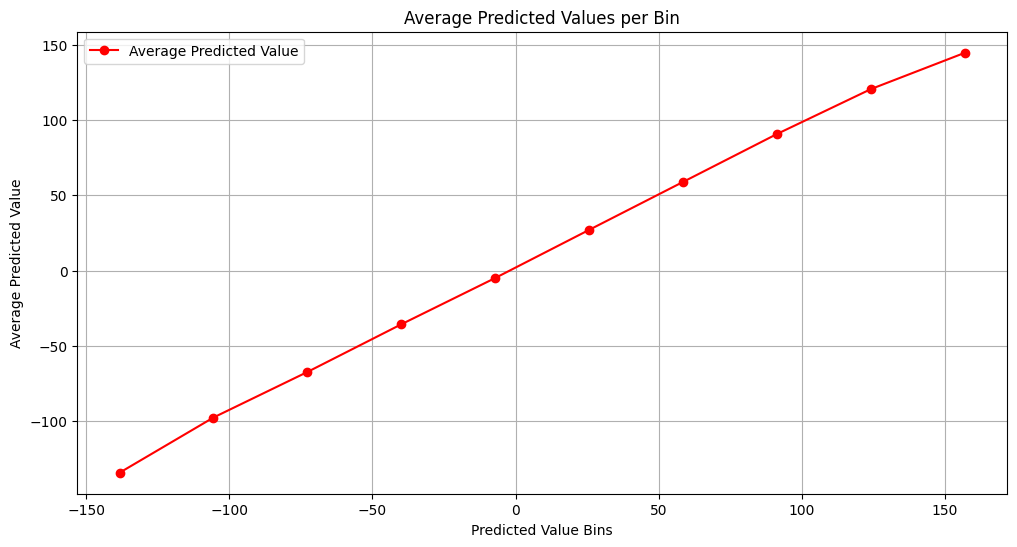

In [59]:
#Assuming 'predictions' is already defined
plot_line_graph_of_bin_averages(predictions)

# TEMP

In [55]:
def segment_and_prepare_df(df, countries=None, age_groups=None, drop_list=None):
    """
    Segments the DataFrame based on specific countries and age groups, and then drops specified columns.
    
    Parameters:
    - df: DataFrame to be processed.
    - countries: List of countries for segmentation. If None, no country-based segmentation is applied.
    - age_groups: List of age groups for segmentation. If None, no age-based segmentation is applied.
    - drop_list: List of columns to be dropped from the DataFrame.
    
    Returns:
    - A DataFrame that has been segmented and had specified columns dropped.
    """
    # Segment DataFrame based on provided countries and age groups
    segmented_df = df.copy()
    if countries is not None:
        segmented_df = segmented_df[segmented_df['Country'].isin(countries)]
    if age_groups is not None:
        segmented_df = segmented_df[segmented_df['Age'].isin(age_groups)]
    
    # Drop specified columns if drop_list is provided
    if drop_list is not None:
        segmented_df = segmented_df.drop(columns=drop_list)
    
    return segmented_df




In [56]:
# Assuming df is your initial dataframe
countries = ['United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'Ireland', 'South Africa']
age_groups = ['18-24', '21-24', '18', '19', '20']
drop_list = [
    'Country',
    'Smartphone ownership',
    'Friends/classmates smartphone ownership',
    'Age of smartphone usage during school hours',
    'Smartphone usage during class hours',
    'Smartphone usage during break'
]

# Segment and prepare the DataFrame
prepared_df = segment_and_prepare_df(df, countries=countries, age_groups=age_groups, drop_list=drop_list)

# Continue with further data preparation steps as needed

KeyError: "['Friends/classmates smartphone ownership'] not found in axis"

In [ ]:
def prepare_dataset(df, drop_list, target_classification, target_regression):
    """Prepares the dataset by dropping specified columns, encoding categorical features, and splitting into features and targets."""
    df_filtered = drop_columns(df, drop_list)
    categorical_features = df_filtered.select_dtypes(include=['object']).columns
    df_filtered = encode_features(df_filtered, categorical_features)
    
    X = df_filtered.drop(columns=[target_classification, target_regression], axis=1)
    y_classification = df_filtered[target_classification]
    y_regression = df_filtered[target_regression]
    
    return X, y_classification, y_regression

def split_dataset(X, y_classification, y_regression, test_size=0.3, random_state=42):
    """Splits the dataset into training and testing sets for both classification and regression tasks."""
    X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=test_size, random_state=random_state)
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train_class, y_test_class, X_train_reg, X_test_reg, y_train_reg, y_test_reg





In [ ]:
# Example of how to use these functions
drop_list = [
    'Country',
    'Smartphone ownership',
    'Friends/classmates smartphone ownership',
    'Age of smartphone usage during school hours',
    'Smartphone usage during class hours',
    'Smartphone usage during break'
]

# Assuming df is your initial dataframe
X, y_classification, y_regression = prepare_dataset(df, drop_list, 'MHQ_Sign', 'Overall MHQ')
X_train, X_test, y_train_class, y_test_class, X_train_reg, X_test_reg, y_train_reg, y_test_reg = split_dataset(X, y_classification, y_regression)

In [ ]:



df_processed = df[set10].copy()

df_processed.loc[:, 'Processed food in diet'] = df_processed['Processed food in diet'].replace({
            'Rarely/never': 'Rarely/Never',
            'A few times in a day': 'Several times a day',
            'Several days a week': 'A few times a week',
            'Many times in a day': 'Several times a day',
            'At least once a day': 'Several times a day',
            'None of the above': 'None of the above SU'
        })




# Filter the encoded dataframe
anglosphere = ['United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'Ireland']


kraj = ['United States']
kraj2 =['India']
        

wiek = ['18-24', '21-24', '18', '19', '20']
wiek2 = ['55-64','45-54']


#df_filtered = df_processed[(df_processed['Country'].isin(kraj)) & (df_processed['Age'].isin(wiek))]


#(2)
#df_filtered = df_processed[(df_processed['Country'].isin(anglosphere))]

#(1)
#df_filtered = df_processed.copy()


#(3) 
#df_filtered = df_processed[(df_processed['Country'].isin(kraj))]


#4 & 5#
#df_filtered = df_processed[(df_processed['Country'].isin(kraj)) & (df_processed['Age'].isin(wiek))]



#df_filtered = df_processed[(df_processed['Age'].isin(wiek2))]



df_filtered.shape